# Experiment Meta

In [1]:
import sys, time
from pathlib import Path

In [2]:
sys.path.append('..')

In [3]:
DATA_ROOT = Path('../data')
RESULTS_ROOT = Path('./results')
EXP_DIR = RESULTS_ROOT / 'self_play_proto_0_control'
EXP_DIR.mkdir(exist_ok=True)
assert not len(list(EXP_DIR.iterdir()))

# Experiment Setup

In [4]:
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import seaborn as sns; sns.set(rc={'figure.figsize':(7,7)})

import gym

from tqdm.notebook import tqdm

import autotrain

import autotrain.envs.utils as utils
from autotrain.envs import AutoTrainEnvironment, Clf, ClfEngine
from autotrain.envs.thresholdout import Thresholdout

import autotrain.agent.A2C.train as train
import autotrain.agent.A2C.buffer as buffer

In [5]:
from functools import partial

In [6]:
DEVICE = torch.device("cuda:4")

In [7]:
CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def reduceds(ds, pct_cap, no_signal=False):
    X, Y = ds.data, ds.targets
    
    if pct_cap:
        cap = int(pct_cap*len(X))
        X, Y = X[:cap], Y[:cap]
        
    
    if no_signal:
        print('suffling labels')
        np.random.shuffle(Y)
    
    ds.data, ds.targets = X, Y

def get_dataset(tfms, no_signal=False, pct_cap=None):
    train = torchvision.datasets.CIFAR10(root=DATA_ROOT / 'cifar-10-data', train=True,
                                        download=True, transform=tfms)

    holdout = torchvision.datasets.CIFAR10(root=DATA_ROOT / 'cifar-10-data', train=False,
                                           download=True, transform=tfms)
        
    # train.data, train.targets = train.data.numpy(),train.targets.numpy()
    # holdout.data, holdout.targets = holdout.data.numpy(),  holdout.targets.numpy()
    
    reduceds(train, pct_cap, no_signal)
    
    print(f'length of trainset: [{len(train)}]; len of holdout: [{len(holdout)}]')
    
    return train, holdout


In [8]:
TFMS = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trnds, valds = get_dataset(TFMS, pct_cap=0.2)

Files already downloaded and verified
Files already downloaded and verified
length of trainset: [10000]; len of holdout: [10000]


In [9]:
def accuracy(data: torch.utils.data.DataLoader, model: nn.Module): # phi
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(data,total=len(data)):
            images, labels = batch[0].to(DEVICE), batch[1]
            outputs = model(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct / total

## Model

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1) # 1->3 for CIFAR
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, len(CLASSES))

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [11]:
model = Classifier()

## Baseline

In [12]:
"""
model, trnds, valds, phi: callable,
criterion: callable = nn.CrossEntropyLoss(), opt: callable = optim.SGD,
lr_init=3e-4, bs_init=16, max_lr=3, dev=None, v=False
"""

baseline = ClfEngine(Classifier(), trnds, valds, accuracy, dev=DEVICE, v=True, opt=optim.SGD)

In [13]:
baseline.clf()

Clf(history=array([], shape=(3, 0), dtype=float64), result=array([], dtype=float64))

In [14]:
baseline.do_updates(len(baseline.trndl) * 3)

[clf_engine]  training loop: started for [1875] updates; BS=[16] LR=[0.0003]!



[clf_engine]  training loop: started for [1250] updates; BS=[16] LR=[0.0003]!



[clf_engine]  training loop: started for [625] updates; BS=[16] LR=[0.0003]!



[clf_engine]  training loop: done!


In [15]:
baseline.optim_step

1875

In [16]:
baseline.result += [baseline.test()]

In [17]:
baseline_clf=baseline.clf()

In [18]:
baseline_clf.history.shape, baseline_clf.result

((3, 1875), array([0.1822]))

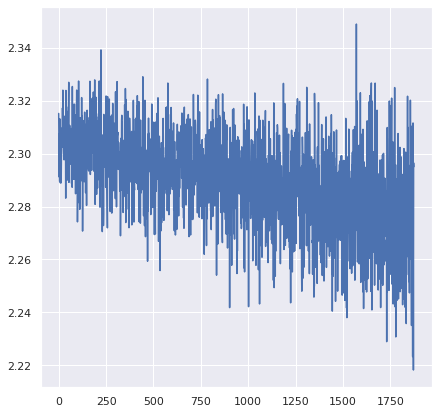

In [19]:
sns.lineplot(x=range(len(baseline_clf.history[0])), y=baseline_clf.history[0])

## Env

In [20]:
ate = gym.make('AutoTrain-v0')
ate.set_config()
ate.seed()

In [21]:
"""
baseline: Clf, competitor: ClfEngine, savedir: Path,
U=30, horizon=50, step_reward=0.1, terminal_reward=10, update_penalty=0.1,
num_workers=4, v=False, device=None
"""
ate.init(baseline=baseline_clf,  
         competitor=ClfEngine(Classifier(),trnds, valds, accuracy, dev=DEVICE, v=True, opt=optim.Adam), 
         savedir=EXP_DIR, U=30, horizon=100, device=DEVICE, v=True, o_dim=(256, 256))

/home/jupyter-skenjeye@broadinst-05974/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[ATE:0]  environment initialised : <autotrain.envs.autotrain_env.AutoTrainEnvironment object at 0x7f9ba49ff128>


(array([[[255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]],
 
        [[255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]],
 
        [[255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]],
 
        ...,


In [22]:
ate.observation_space

Box(7, 256, 256)

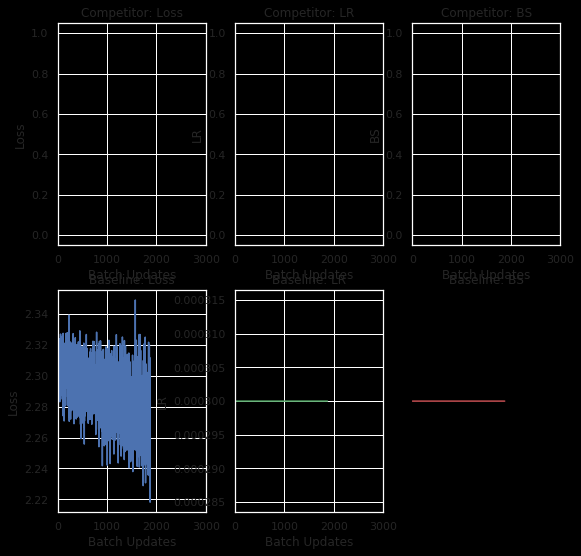

In [23]:
fg = ate.render()

In [24]:
O_t,R_t,is_stop,debug = ate.step([1.2,1.2,0,0])

[ATE:0]  action [[1.2, 1.2, 0, 0]] recieved
[clf_engine]  scaled BS by [1.2]; BS=[19]
[clf_engine]  scaled LR by [1.2]; LR=[0.0003]
[clf_engine]  training loop: started for [30] updates; BS=[19] LR=[0.00035999999999999997]!



[clf_engine]  training loop: done!
[ATE:1]  reward at the end of time step is [-0.1]


In [25]:
O_t.shape

(7, 256, 256)

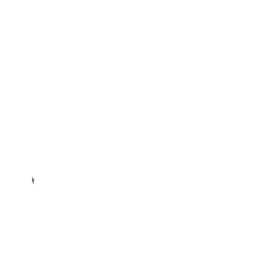

In [26]:
debug['plots'][0]

## Agent

In [27]:
ate.action_space.shape

(4,)

In [28]:
ate.action_space.high

array([10., 10.,  1.,  1.], dtype=float32)

In [29]:
GAMMA = 0.99
TAU = 0.001

from torch.autograd import Variable

class Trainer:

    def __init__(self, state_shape: np.array, action_dim: int, action_lim: np.array, ram, bs=32,
                 lr=3e-4,dev=None):
        """
        :param state_dim: Dimensions of state (int)
        :param action_dim: Dimension of action (int)
        :param action_lim: Used to limit action in [-action_lim,action_lim]
        :param ram: replay memory buffer object
        :return:
        """
        self.state_shape = state_shape
        self.action_dim = action_dim
        self.action_lim = torch.from_numpy(action_lim)

        self.ram = ram
        self.iter = 0
        self.noise = autotrain.agent.A2C.utils.OrnsteinUhlenbeckActionNoise(self.action_dim)

        self.bs = bs
        self.lr = lr
        self.dev = dev

        self.actor = autotrain.agent.A2C.model.Actor(self.state_shape, self.action_dim, self.action_lim)
        self.target_actor = autotrain.agent.A2C.model.Actor(self.state_shape, self.action_dim, self.action_lim)

        self.critic = autotrain.agent.A2C.model.Critic(self.state_shape, self.action_dim)
        self.target_critic = autotrain.agent.A2C.model.Critic(self.state_shape, self.action_dim)
        
        if self.dev:
            self.actor.to(self.dev)
            self.target_actor.to(self.dev)

            self.critic.to(self.dev)
            self.target_critic.to(self.dev)
            
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), self.lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), self.lr)
        
        
        autotrain.agent.A2C.utils.hard_update(self.target_actor, self.actor)
        autotrain.agent.A2C.utils.hard_update(self.target_critic, self.critic)

    def get_exploitation_action(self, state):
        """
        gets the action from target actor added with exploration noise
        :param state: state (Numpy array)
        :return: sampled action (Numpy array)
        """
        shape = state.shape
        state = torch.FloatTensor(state).view(1, *shape)
        state = Variable(state).to(self.dev) if self.dev else Variable(state)

        action = self.target_actor.forward(state).detach()
        return action.data.numpy()

    def get_exploration_action(self, state):
        """
        gets the action from actor added with exploration noise
        :param state: state (Numpy array)
        :return: sampled action (Numpy array)
        """
        shape = state.shape
        state = torch.FloatTensor(state).view(1, *shape)
        state = Variable(state).to(self.dev) if self.dev else Variable(state)

        action = self.actor.forward(state).detach()
        new_action = action.data.numpy() + (self.noise.sample() * self.action_lim)
        return new_action

    def optimize(self):
        """
        Samples a random batch from replay memory and performs optimization
        :return:
        """
        s1, a1, r1, s2 = self.ram.sample(self.bs)

        s1 = Variable(torch.from_numpy(s1))
        a1 = Variable(torch.from_numpy(a1))
        r1 = Variable(torch.from_numpy(r1))
        s2 = Variable(torch.from_numpy(s2))

        # ---------------------- optimize critic ----------------------
        # Use target actor exploitation policy here for loss evaluation
        a2 = self.target_actor.forward(s2).detach()
        next_val = torch.squeeze(self.target_critic.forward(s2, a2).detach())
        # y_exp = r + gamma*Q'( s2, pi'(s2))
        y_expected = r1 + GAMMA * next_val
        # y_pred = Q( s1, a1)
        y_predicted = torch.squeeze(self.critic.forward(s1, a1))
        # compute critic loss, and update the critic
        loss_critic = F.smooth_l1_loss(y_predicted, y_expected)
        self.critic_optimizer.zero_grad()
        loss_critic.backward()
        self.critic_optimizer.step()

        # ---------------------- optimize actor ----------------------
        pred_a1 = self.actor.forward(s1)
        loss_actor = -1 * torch.sum(self.critic.forward(s1, pred_a1))
        self.actor_optimizer.zero_grad()
        loss_actor.backward()
        self.actor_optimizer.step()

        autotrain.agent.A2C.utils.soft_update(self.target_actor, self.actor, TAU)
        autotrain.agent.A2C.utils.soft_update(self.target_critic, self.critic, TAU)

    # if self.iter % 100 == 0:
    # 	print 'Iteration :- ', self.iter, ' Loss_actor :- ', loss_actor.data.numpy(),\
    # 		' Loss_critic :- ', loss_critic.data.numpy()
    # self.iter += 1

    def save(self, savedir):
        """
        saves the target actor and critic models
        :param episode_count: the count of episodes iterated
        :return:
        """
        torch.save(self.target_actor.state_dict(), savedir / f"actor.pt")
        torch.save(self.target_critic.state_dict(), savedir / f"critic.pt")

    def load(self, savedir):
        """
        loads the target actor and critic models, and copies them onto actor and critic models
        :param episode: the count of episodes iterated (used to find the file name)
        :return:
        """
        self.actor.load_state_dict(torch.load(savedir / f"actor.pt"))
        self.critic.load_state_dict(torch.load(savedir / f"critic.pt"))
        autotrain.agent.A2C.utils.hard_update(self.target_actor, self.actor)
        autotrain.agent.A2C.utils.hard_update(self.target_critic, self.critic)


In [30]:
MAX_EPISODES = 5000
MAX_STEPS = 1000
MAX_BUFFER = 1000000

S_DIM = ate.observation_space.shape
A_DIM = ate.action_space.shape[0]
A_MAX = ate.action_space.high

ram = buffer.MemoryBuffer(MAX_BUFFER)
trainer = Trainer(S_DIM, A_DIM, A_MAX, ram, dev=DEVICE)

(7, 256, 256) 7 256 256
(7, 256, 256) 7 256 256
(7, 256, 256) 7 256 256
(7, 256, 256) 7 256 256


# Experiment Execution

## Agent Training Loop

In [31]:
from itertools import count
import gc

In [32]:
for ep in range(MAX_EPISODES):
    observation, _ = ate.reset()

    for t in count():
        start_time = time.time()
            
        action = trainer.get_exploration_action(observation)

        new_observation, reward, done, info = ate.step(action)
        
        new_observation[new_observation==255] = 0

        ram.add(observation, action, reward, new_observation)

        observation = new_observation

        # perform optimization
        trainer.optimize()
        print(f'[ATA episode {i_episode}]: took [{time.time() - start_time:.1f}] seconds for one full step')

        if done:
            break

    gc.collect()
    
    # save env, buffer, agent
    EP_DIR = EXP_DIR / f'{ep}_episode'
    EP_DIR.mkdir(exist_ok=True)
    
    ate.save(EP_DIR)
    ram.save(EXP_DIR / 'mem.pkl')
    trainer.save(EP_DIR)

[clf_engine]  re-init complete


/home/jupyter-skenjeye@broadinst-05974/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[ATE:0]  environment initialised : <autotrain.envs.autotrain_env.AutoTrainEnvironment object at 0x7f9ba49ff128>
torch.Size([1, 8, 28, 28])
tensor([[-0.0664,  0.0084,  0.0296,  0.0405]], device='cuda:4',
       grad_fn=<TanhBackward>) tensor([10., 10.,  1.,  1.]) True False


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


RuntimeError: expected device cuda:4 but got device cpu

In [ ]:
trainer.action_lim.to(DEVICE)